# Analyzing Clairy sensor data

Clairy is a smart device that can clean your room's air as well as measure indoor air quality levels, humidity and temperature.

## Todo
* Map IAQ to categories
* Find hours with worst / best air quality
* Describe findings
* …

## Import required packages

In [38]:
import pandas as pd
import requests
import json
from configparser import ConfigParser

# Display plots inline
%matplotlib inline

# Show multiple outputs in Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Let's fetch the data

In [39]:
# External config file, so API key and serial are hidden from Github
# Create a config.ini file with the following content to use the script
# [auth]  
# serial = yourSerial123
# token = yourAPIKey123
# Check Readme on how to get this info

config = ConfigParser()  
config.read('config.ini')  
token = config.get('auth', 'token')  
serial = config.get('auth', 'serial') 


# Get data from Clairy API
base_url = "http://api.clairy.co/api/Device/GetAllData"

serial = "261700143"
start_date = "2017-08-01"
endpoint = base_url + "?Serial=" + serial + "&StartDate=" + start_date

headers = {"Authorization": "Bearer " + token}
json_data = requests.get(endpoint, headers = headers).json()

['config.ini']

In [40]:
# Get historical data from Wunderground
# Replace ID=… with your local weather station

wunder = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=IMUNICH268&graphspan=month&month=8&day=1&year=2017&format=1'
hist_weather = pd.read_csv(wunder)

## Formatting the data

In [41]:
# Clairy
json_str = json.dumps(json_data)
data = pd.read_json(json_str)
data.set_index('Date', inplace=True)
data.drop(['Device', 'Serial', 'FanIsOn'], axis=1, inplace=True)
data = data[data.index < '2017-09-01']

data.columns = ['Inside_Humidity', 'Inside_IAQ', 'Inside_Temperature']

# Average daily temperature
data = data.resample('D').mean()

# Check if all looks good
data.describe()
data.head()

,Inside_Humidity,Inside_IAQ,Inside_Temperature
count,31.000000,31.000000,31.000000
mean,80.887142,955.477151,21.712321
std,6.631523,39.238744,1.296835
min,68.675000,856.597222,18.288889
25%,76.523264,945.659722,21.145833
50%,82.733333,964.930556,21.914583
75%,84.821528,979.166667,22.788542
max,92.800694,1000.000000,23.319444


,Inside_Humidity,Inside_IAQ,Inside_Temperature
Date,,,
2017-08-01,84.379861,979.166667,23.103472
2017-08-02,91.848611,989.930556,22.859722
2017-08-03,92.800694,969.444444,22.879167
2017-08-04,91.992361,952.430556,22.427083
2017-08-05,85.254167,961.805556,21.914583


In [42]:
# Wunderground

hist_weather = hist_weather[hist_weather['Date'] != '<br>']
hist_weather.Date = pd.to_datetime(hist_weather.Date)
hist_weather.set_index('Date', inplace=True)
hist_weather = hist_weather[['TemperatureAvgC','HumidityAvg']]
hist_weather.columns = ['Outside_Temperature', 'Outside_Humidity']

# Again, let's do a sanity check
hist_weather.describe()
hist_weather.head()

,Outside_Temperature,Outside_Humidity
count,31.000000,31.000000
mean,22.867742,68.451613
std,3.910276,7.753875
min,13.700000,58.000000
25%,19.950000,62.000000
50%,23.700000,66.000000
75%,25.600000,73.500000
max,30.100000,88.000000


,Outside_Temperature,Outside_Humidity
Date,,
2017-08-01,30.1,60.0
2017-08-02,26.2,75.0
2017-08-03,27.4,62.0
2017-08-04,25.7,65.0
2017-08-05,25.9,62.0


## Bringing the dataframes together

In [43]:
joined = data.join(hist_weather, how='outer')

# Check data
joined.describe()
joined.head()

,Inside_Humidity,Inside_IAQ,Inside_Temperature,Outside_Temperature,Outside_Humidity
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,80.887142,955.477151,21.712321,22.867742,68.451613
std,6.631523,39.238744,1.296835,3.910276,7.753875
min,68.675000,856.597222,18.288889,13.700000,58.000000
25%,76.523264,945.659722,21.145833,19.950000,62.000000
50%,82.733333,964.930556,21.914583,23.700000,66.000000
75%,84.821528,979.166667,22.788542,25.600000,73.500000
max,92.800694,1000.000000,23.319444,30.100000,88.000000


,Inside_Humidity,Inside_IAQ,Inside_Temperature,Outside_Temperature,Outside_Humidity
Date,,,,,
2017-08-01,84.379861,979.166667,23.103472,30.1,60.0
2017-08-02,91.848611,989.930556,22.859722,26.2,75.0
2017-08-03,92.800694,969.444444,22.879167,27.4,62.0
2017-08-04,91.992361,952.430556,22.427083,25.7,65.0
2017-08-05,85.254167,961.805556,21.914583,25.9,62.0


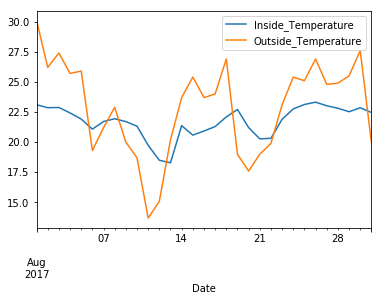

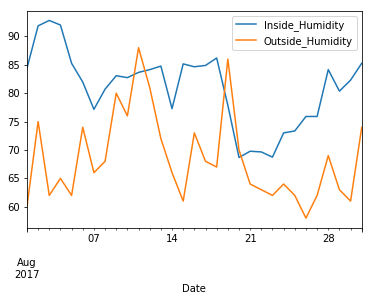

In [44]:
joined[['Inside_Temperature', 'Outside_Temperature']].plot.line()
joined[['Inside_Humidity', 'Outside_Humidity']].plot.line()

In [24]:
# Check how inside and outside temperature correlate
# Pearson correlation coefficient

joined.corr()

,Inside_Humidity,Inside_IAQ,Inside_Temperature,Outside_Temperature,Outside_Humidity
Inside_Humidity,1.000000,0.211706,0.040049,0.266059,0.227249
Inside_IAQ,0.211706,1.000000,-0.336567,-0.103693,0.256365
Inside_Temperature,0.040049,-0.336567,1.000000,0.697325,-0.415885
Outside_Temperature,0.266059,-0.103693,0.697325,1.000000,-0.743902
Outside_Humidity,0.227249,0.256365,-0.415885,-0.743902,1.000000
